先import一些library

In [1]:
import datetime
import os
import time
import warnings
import gc
# import presets
import torch
import torch.utils.data
import torchvision
from tmp_modules import utils,transforms

# from coco_utils import get_coco
from torch import nn
from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as F, InterpolationMode
import torchvision.transforms as transforms
try:
    from pytorch_model_summary import summary
except:
    !pip install pytorch-model-summary
    from pytorch_model_summary import summary

try:
    from torchviz import make_dot
except:
    !pip install torchviz
    from torchviz import make_dot

import transformers
try:
    import datasets
except:
    !pip install cchardet
    !pip install datasets
    import datasets
    
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from IPython.display import clear_output, display

try:
        from thop import profile
except:
        !pip install thop

import torch
from transformers import SamModel, SamProcessor

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


先定義一些function

In [2]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    """
    print("student_outputs size = ", student_outputs["out"].size())
    print("student_outputs = ", student_outputs["out"])
    print("teacher_outputs size = ", teacher_outputs[0].size())
    print("teacher_outputs = ", teacher_outputs[0])
    """
    # Calculate Cross Entropy
    original_loss = nn.functional.cross_entropy(student_outputs["out"], labels, ignore_index=255)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0][0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs["out"][0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # 總損失為原始損失加上蒸餾損失
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss

    return total_loss

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    model.to(device)

    header = "Test:"
    num_processed_samples = 0
    total_loss            = 0
    with torch.inference_mode():
        for image, target in data_loader:
            image, target = image.to(device), target.to(device)

            ###
            target = target.squeeze(1)
            # Convert target to Long type
            target = target.type(torch.LongTensor).to(device)
            
            output = model(image)
            loss = criterion(output, target)
            total_loss += loss.item()
            # output = output["out"]
            # confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]
            
            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()
    return total_loss/ num_processed_samples

# 用enumerate去iterate through all the data.
def train_one_epoch_01(student_model, teacher_model, processor, criterion, teacher_ratio, temperature, optimizer, data_loader, lr_scheduler, device, pbar, scaler=None):
    student_model.train()
    teacher_model.eval()
    training_loss = []
    for idx, (image, target) in enumerate(data_loader):
        bbox = [[[get_bounding_box(np.array(target))]]] # 先用 target 找出 bounding box 的座標

        image, target = image.to(device), target.to(device)
        ### ground truth given by annotation
        target = target.squeeze(1)
        # Convert target to Long type
        target = target.type(torch.LongTensor).to(device)
        ############################################################### Teacher Model : SAM
        # Retrieve the image embeddings
        # processor
        inputs = processor(image, return_tensors="pt").to(device)
        image_embeddings = teacher_model.get_image_embeddings(inputs["pixel_values"])
        
        # 送到processor計算遮罩
        # inputs = processor(image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)
        #inputs = processor(image, return_tensors="pt").to(device)
        inputs = processor(image, input_boxes=[bbox], return_tensors="pt").to(device)

        inputs.pop("pixel_values", None)
        inputs.update({"image_embeddings": image_embeddings})

        """
        with torch.no_grad():
            outputs = model(**inputs)

        masks, teacher_output = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
        """
        ###############################################################
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            student_output = student_model(image)
            sam_outputs = teacher_model(**inputs)
            # print("sam_outputs = ", sam_outputs)
            masks, teacher_output = processor.image_processor.post_process_masks(sam_outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
            #print("output-->", output)
            loss = criterion(student_output, teacher_output, target, teacher_ratio, temperature)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(idx, values=[("loss",loss.item())])

        training_loss.append(loss.item())

        del image, target, student_output, loss

        gc.collect()
        torch.cuda.empty_cache()
    '''
        except:
            print('except: *************')
            error_count += 1
            if error_count < 10:
                model.to('cpu')
                gc.collect()
                torch.cuda.empty_cache()
                model.to(device)
                model.train()
            else:
                raise RuntimeError('GPU out of memory error')
    '''
    return np.mean(np.array(training_loss))

def train(student_model, teacher_model, processor, epochs, data_loader, data_loader_valid, teacher_ratio, temperature, train_size, early_stop=0, model_pathname=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device, ":",torch.cuda.get_device_name(0))
    gc.collect()
    torch.cuda.empty_cache()

    student_model.to(device)
    teacher_model.to(device)
    if hasattr(student_model,'backbone'):
        params_to_optimize = [
            {"params": [p for p in student_model.backbone.parameters() if p.requires_grad]},
            {"params": [p for p in student_model.classifier.parameters() if p.requires_grad]},
        ]
    else:
        params_to_optimize = [{ "params": student_model.parameters() }]

    optimizer = torch.optim.Adam(params_to_optimize)
    scaler = None #torch.cuda.amp.GradScaler()
    iters_per_epoch = len(data_loader)
    lr_scheduler    = None # PolynomialLR(optimizer, total_iters=iters_per_epoch * epochs, power=0.9)
    training_loss   = []
    val_loss        = []
    min_val_loss    = np.inf
    min_val_epoch   = 0
    start_time = time.time()

    n_batch = len(data_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch,stateful_metrics=['val_loss'])

    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_train_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), "weights")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end     
    for epoch in range(epochs):
        
        print(f'Epoch {epoch+1}/{epochs}')

        #tr_loss = train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, 10, scaler)
        tr_loss = train_one_epoch_01(student_model, teacher_model, processor, KD_criterion, teacher_ratio, temperature, optimizer, data_loader, lr_scheduler, device, pbar, scaler)
        
        #print(tr_loss)
        training_loss.append(tr_loss)

        if data_loader_valid is not None:
            # def evaluate(model, data_loader, device, num_classes):
            # def evaluate01(student_model, teacher_model, processor, data_loader, device, criterion):
            v_loss = evaluate(student_model, data_loader_valid, device=device, num_classes=2)
            #v_loss = evaluate01(student_model, teacher_model, processor, data_loader_valid, KD_criterion, device=device)
            val_loss.append(v_loss)
            pbar.update(n_batch, values=[('val_loss', v_loss)])

            # save the parameters with the least loss
            if v_loss < min_val_loss:
                min_val_loss = v_loss
                min_val_epoch= epoch
                if model_pathname is not None:
                    torch.save(student_model.state_dict(),model_pathname)
                    print(f"Saved model weights to '{model_pathname}'.")

            # early stop
            if early_stop > 0 and epoch - min_val_epoch >= early_stop:
                break

        if lr_scheduler is not None:
            checkpoint = {
                "model": student_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "epoch": epoch,
            } 
        else:
            checkpoint = {
                "model": student_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            } 

    if data_loader_valid is not None and model_pathname is not None:
        student_model.load_state_dict(torch.load(model_pathname))

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")
    return {'loss':training_loss,'val_loss':val_loss}

def showSegmentationResult(model, dataset, num_images=10):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for i, idx in enumerate(range(min(len(dataset), num_images))):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))   
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(target.permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')

        # Model Prediction
        plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        overlay = image.clone()
        overlay[0, labels == 1] = 1
        plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(np.transpose(overlay.squeeze().cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

    plt.show()

    print("outputs['out'] size = ", outputs['out'].size())
    print(outputs['out'])
    print("labels = ", labels)
    return

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def compute_metrics(prediction, ground_truth, calculate_accuracy=True, calculate_precision=True, calculate_recall=True, calculate_f1=True):
    """
    Compute performance metrics for binary classification.

    :param prediction: Predicted binary mask
    :param ground_truth: Ground truth binary mask
    :param calculate_accuracy: Whether to calculate accuracy
    :param calculate_precision: Whether to calculate precision
    :param calculate_recall: Whether to calculate recall
    :param calculate_f1: Whether to calculate F1 score
    :return: Dictionary with requested metrics
    """
    TP = np.sum((prediction == 1) & (ground_truth == 1))
    FP = np.sum((prediction == 1) & (ground_truth == 0))
    TN = np.sum((prediction == 0) & (ground_truth == 0))
    FN = np.sum((prediction == 0) & (ground_truth == 1))

    metrics = {}

    if calculate_accuracy:
        metrics['accuracy'] = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    if calculate_precision:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        metrics['precision'] = precision

    if calculate_recall:
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['recall'] = recall

    if calculate_f1:
        if 'precision' not in metrics:
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        if 'recall' not in metrics:
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['f1_score'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return metrics

def evaluate_metrics(model, dataset):# IoU score 和 4個指標
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    total_metrics = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'iou': 0.0}
    num_images = len(dataset)

    for idx in range(num_images):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        prediction_mask = (labels == 1)
        target_mask = (target.squeeze() == 1).numpy()  # Assuming your ground truth is also a binary mask

        metrics = compute_metrics(prediction_mask, target_mask)
        
        intersection = np.logical_and(target_mask, prediction_mask)
        union = np.logical_or(target_mask, prediction_mask)
        iou = intersection.sum() / union.sum()

        for key in total_metrics.keys():
            if key in metrics:
                total_metrics[key] += metrics[key]
        total_metrics['iou'] += iou

    # Calculate average of each metric
    for key in total_metrics.keys():
        total_metrics[key] /= num_images

    print(f"Average metrics over {num_images} images: {total_metrics}")

    return total_metrics

定義Segformer，直接用包好的

In [3]:
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

class SegFormer(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()})
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
    
num_classes = 2
segformer_transform   = transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128),antialias=True)])
segformer_target_transform = transforms.Compose([lambda x:torch.from_numpy(cv2.resize(np.asarray(x),(128,128),cv2.INTER_NEAREST).astype(np.int64)-1)])


segformer_model_tmp = SegFormer(num_classes)

print(summary(segformer_model_tmp, torch.zeros((1, 3, 1024, 1024)), show_input=True, show_parent_layers=True, max_depth=1))

# 計算FLOP
flops, params = profile(segformer_model_tmp, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)
print("FLOPs =", '{:,.0f}'.format(flops))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-------------------------------------------------------------------------------------------------------------
   Parent Layers                          Layer (type)            Input Shape         Param #     Tr. Param #
       SegFormer    SegformerForSemanticSegmentation-1     [1, 3, 1024, 1024]      13,677,762      13,677,762
Total params: 13,677,762
Trainable params: 13,677,762
Non-trainable params: 0
-------------------------------------------------------------------------------------------------------------
FLOPs = 52,974,059,520


定義SAM

In [4]:
############################################################### Teacher Model : SAM
# define SAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

print(summary(sam_model, torch.zeros((1, 3, 1024, 1024)).to(device), show_input=True, show_parent_layers=True, max_depth=1))
"""
# 計算FLOP
flops, params = profile(sam_model, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)
print("FLOPs =", '{:,.0f}'.format(flops))
"""

---------------------------------------------------------------------------------------------
   Parent Layers          Layer (type)            Input Shape         Param #     Tr. Param #
        SamModel    SamVisionEncoder-1     [1, 3, 1024, 1024]     637,026,048     637,026,048
        SamModel    SamPromptEncoder-2                                  6,220           6,220
        SamModel      SamMaskDecoder-3                              4,058,340       4,058,340
Total params: 641,090,608
Trainable params: 641,090,608
Non-trainable params: 0
---------------------------------------------------------------------------------------------


'\n# 計算FLOP\nflops, params = profile(sam_model, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)\nprint("FLOPs =", \'{:,.0f}\'.format(flops))\n'

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SplashDataSet(Dataset):
    def __init__(self, data_dir, train_size, val_size, transform=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, 'images')
        self.annotations_dir = os.path.join(data_dir, 'annotations')
        self.images_list = os.listdir(self.images_dir)
        self.annotations_list = os.listdir(self.annotations_dir)
        assert len(self.images_list) == len(self.annotations_list), "Number of images and annotations should be the same."
         # 隨機選擇訓練集和驗證集
        if train_size:
            train_indices = np.random.choice(len(self.images_list), train_size, replace=False)
            self.images_list = [self.images_list[i] for i in train_indices]
            self.annotations_list = [self.annotations_list[i] for i in train_indices]
        
        if val_size:
            val_indices = np.random.choice(len(self.images_list), val_size, replace=False)
            self.images_list = [self.images_list[i] for i in val_indices]
            self.annotations_list = [self.annotations_list[i] for i in val_indices]
        """
        self.train_indices = train_indices
        self.val_indices = val_indices
        """
        self.transform = transform
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        # Read original image
        img_name = os.path.join(self.images_dir, self.images_list[idx])
        image = Image.open(img_name)

        # Read mask
        mask_name = os.path.join(self.annotations_dir, self.annotations_list[idx])
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        return image, mask

In [6]:
%%time
# trial
from torch.utils.data import Subset, DataLoader
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# transform the image
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

data_folder = select_folder()

# Knowledge Distillation Parameters
teacher_ratio = 0.7 # The ground truth ratio will be (1-teacher_ratio)
temperature = 1

# 初始化 KFold
kfold = KFold(n_splits=5, shuffle=False)

# 定義不同的訓練集大小
train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 125, 150, 200]  # 每個訓練集的大小
val_size = None  # 驗證集大小

# 初始化空的列表來存儲不同訓練集大小下的平均驗證損失
mean_val_losses = []
std_val_losses = []
mean_val_losses_KD = []
std_val_losses_KD = []

all_metrics_normal = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'iou': []}
all_metrics_KD = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'iou': []}

# 迴圈遍歷不同的訓練集大小
for train_size in train_sizes:
    val_losses = []  # 存儲每個 fold 的驗證損失
    val_losses_KD = []

    # 初始化存储指标的 dictionary
    metrics_normal = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'iou': []}
    metrics_KD = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'iou': []}

    # 宣告 Segformer
    segformer_model_original = SegFormer(num_classes)    
    segformer_model_distillation = SegFormer(num_classes)

    # create SplashDataSet
    dataset = SplashDataSet(data_dir=data_folder, train_size=train_size, val_size=val_size, transform=transform)
    
    # 迴圈遍歷每一個 fold
    for fold, (train_index, val_index) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold+1}')
        
        # 分割訓練集和驗證集
        train_dataset = Subset(dataset, train_index)
        val_dataset = Subset(dataset, val_index)
        
        # 初始化 DataLoader
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        # 在這裡進行模型的訓練和評估
        lc = train(segformer_model_original, sam_model, processor, 10, train_loader, val_loader, 0, temperature, train_size)
        lc_KD = train(segformer_model_distillation, sam_model, processor, 10, train_loader, val_loader, teacher_ratio, temperature, train_size)

        """"""
        # 取最後一個 epoch 的驗證損失
        val_loss = lc['val_loss'][-1]
        val_losses.append(val_loss)
        
        val_loss_KD = lc_KD['val_loss'][-1]
        val_losses_KD.append(val_loss_KD)

        metrics_normal_fold = evaluate_metrics(segformer_model_original, val_dataset)
        metrics_KD_fold = evaluate_metrics(segformer_model_distillation, val_dataset)

        for key in metrics_normal_fold.keys():
            metrics_normal[key].append(metrics_normal_fold[key])
            metrics_KD[key].append(metrics_KD_fold[key])
            
    for key in metrics_normal.keys():
        all_metrics_normal[key].append(np.mean(metrics_normal[key]))
        all_metrics_KD[key].append(np.mean(metrics_KD[key]))

    """"""
    # 計算平均驗證損失並添加到列表中
    mean_val_loss = np.mean(val_losses)
    mean_val_losses.append(mean_val_loss)
    std_val_loss = np.std(val_losses)
    std_val_losses.append(std_val_loss)
    
    mean_val_loss_KD = np.mean(val_losses_KD)
    mean_val_losses_KD.append(mean_val_loss_KD)
    std_val_loss_KD = np.std(val_losses_KD)
    std_val_losses_KD.append(std_val_loss_KD)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 747ms/step - loss: 0.6527 - val_loss: 0.6059
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 679ms/step - loss: 0.4936 - val_loss: 0.4673
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 664ms/step - loss: 0.3971 - val_loss: 0.5276
Epoch 4/10
4/4 [==============================] - 19s 667ms/step - loss: 0.3307 - val_loss: 0.4776
Epoch 5/10
4/4 [==============================] - 22s 681ms/step - loss: 0.2850 - val_loss: 0.3857
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 6/10
4/4 [==============================] - 26s 667ms/step - loss: 0.2529 - val_loss: 0.3326
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetec

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
8/8 [==============================] - 7s 783ms/step - loss: 0.4854 - val_loss: 0.5511
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 14s 790ms/step - loss: 0.3295 - val_loss: 0.1727
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 21s 785ms/step - loss: 0.2543 - val_loss: 0.1495
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_10.pth'.
Epoch 4/10
8/8 [==============================] - 28s 784ms/step - loss: 0.2188 - val_loss: 0.1408
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_10.pth'.
Epoch 5/10
8/8 [==============================] - 35s 784ms/step - loss: 0.2019 - val_loss: 0.1420
Epoc

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
12/12 [==============================] - 11s 825ms/step - loss: 0.3685 - val_loss: 0.5161
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 21s 817ms/step - loss: 0.2532 - val_loss: 0.0560
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 32s 817ms/step - loss: 0.1947 - val_loss: 0.0604
Epoch 4/10
12/12 [==============================] - 42s 822ms/step - loss: 0.1671 - val_loss: 0.1184
Epoch 5/10
12/12 [==============================] - 53s 818ms/step - loss: 0.1485 - val_loss: 0.1290
Epoch 6/10
12/12 [==============================] - 64s 832ms/step - loss: 0.1376 - val_loss: 0.1093
Epoch 7/10
12/12 [==============================] - 74s 813ms/step - loss: 0.1279 - val_loss: 0.1231
Epoch 8/10
12/12 [=====

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
16/16 [==============================] - 14s 839ms/step - loss: 0.3925 - val_loss: 0.3012
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 28s 839ms/step - loss: 0.2558 - val_loss: 0.2237
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 43s 852ms/step - loss: 0.2085 - val_loss: 0.1472
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_20.pth'.
Epoch 4/10
16/16 [==============================] - 57s 838ms/step - loss: 0.1846 - val_loss: 0.3173
Epoch 5/10
16/16 [==============================] - 71s 838ms/step - loss: 0.1695 - val_loss: 0.1537
Epoch 6/10
16/16 [==============================] - 85s 835ms/step - loss: 0.1583 - val_loss: 0.1631
Epoch 7/

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
20/20 [==============================] - 18s 848ms/step - loss: 0.3216 - val_loss: 0.1750
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 36s 852ms/step - loss: 0.2144 - val_loss: 0.1389
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 53s 851ms/step - loss: 0.1711 - val_loss: 0.1390
Epoch 4/10
20/20 [==============================] - 71s 850ms/step - loss: 0.1486 - val_loss: 0.1132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_25.pth'.
Epoch 5/10
20/20 [==============================] - 89s 849ms/step - loss: 0.1355 - val_loss: 0.1334
Epoch 6/10
20/20 [==============================] - 106s 849ms/step - loss: 0.1257 - val_loss: 0.1136
Epoch 7

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
24/24 [==============================] - 21s 858ms/step - loss: 0.2298 - val_loss: 0.0552
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 43s 855ms/step - loss: 0.1607 - val_loss: 0.0920
Epoch 3/10
24/24 [==============================] - 64s 856ms/step - loss: 0.1363 - val_loss: 0.0588
Epoch 4/10
24/24 [==============================] - 85s 861ms/step - loss: 0.1219 - val_loss: 0.0528
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_30.pth'.
Epoch 5/10
24/24 [==============================] - 106s 854ms/step - loss: 0.1124 - val_loss: 0.0690
Epoch 6/10
24/24 [==============================] - 127s 853ms/step - loss: 0.1064 - val_loss: 0.0523
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_30.pth'.
Epoch 

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
40/40 [==============================] - 36s 870ms/step - loss: 0.1665 - val_loss: 0.1280
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 71s 866ms/step - loss: 0.1251 - val_loss: 0.1955
Epoch 3/10
40/40 [==============================] - 106s 868ms/step - loss: 0.1090 - val_loss: 0.1331
Epoch 4/10
40/40 [==============================] - 142s 872ms/step - loss: 0.1012 - val_loss: 0.5086
Epoch 5/10
40/40 [==============================] - 178s 871ms/step - loss: 0.0967 - val_loss: 0.1174
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_50.pth'.
Epoch 6/10
40/40 [==============================] - 213s 873ms/step - loss: 0.0930 - val_loss: 0.6025
Epoch 7/10
40/40 [==============================] - 249s 875ms/step - loss: 0.0903 - val_loss: 0.0866
Saved model weight

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
48/48 [==============================] - 40s 814ms/step - loss: 0.1956 - val_loss: 0.1071
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 80s 816ms/step - loss: 0.1409 - val_loss: 0.1316
Epoch 3/10
48/48 [==============================] - 121s 853ms/step - loss: 0.1242 - val_loss: 0.1290
Epoch 4/10
48/48 [==============================] - 164s 874ms/step - loss: 0.1141 - val_loss: 0.0788
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_60.pth'.
Epoch 5/10
48/48 [==============================] - 207s 873ms/step - loss: 0.1070 - val_loss: 0.0735
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_60.pth'.
Epoch 6/10
48/48 [==============================] - 249s 873ms/step - loss: 0.1013 - val_loss: 0.0667
Save

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
64/64 [==============================] - 53s 816ms/step - loss: 0.1461 - val_loss: 0.0593
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 106s 810ms/step - loss: 0.1104 - val_loss: 0.0989
Epoch 3/10
64/64 [==============================] - 158s 813ms/step - loss: 0.0989 - val_loss: 0.1287
Epoch 4/10
64/64 [==============================] - 211s 813ms/step - loss: 0.0913 - val_loss: 0.0672
Epoch 5/10
64/64 [==============================] - 264s 811ms/step - loss: 0.0856 - val_loss: 0.1396
Epoch 6/10
64/64 [==============================] - 317s 814ms/step - loss: 0.0807 - val_loss: 0.0395
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_80.pth'.
Epoch 7/10
64/64 [==============================] - 369s 814ms/step - loss: 0.0770 - val_loss: 0.0436
Epoch 8/10
64/64 

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
80/80 [==============================] - 71s 883ms/step - loss: 0.1433 - val_loss: 0.0882
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 143s 880ms/step - loss: 0.1161 - val_loss: 0.0578
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 214s 881ms/step - loss: 0.1046 - val_loss: 0.1205
Epoch 4/10
80/80 [==============================] - 285s 884ms/step - loss: 0.0985 - val_loss: 0.1058
Epoch 5/10
80/80 [==============================] - 357s 882ms/step - loss: 0.0939 - val_loss: 0.0619
Epoch 6/10
80/80 [==============================] - 428s 881ms/step - loss: 0.0906 - val_loss: 0.0762
Epoch 7/10
80/80 [==============================] - 499s 884ms/step - loss: 0.0883 - val_loss: 0.1183
Epoch 8/10
80/8

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
100/100 [==============================] - 82s 815ms/step - loss: 0.1376 - val_loss: 0.0863
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_125.pth'.
Epoch 2/10
100/100 [==============================] - 164s 810ms/step - loss: 0.1112 - val_loss: 0.1517
Epoch 3/10
100/100 [==============================] - 246s 810ms/step - loss: 0.1013 - val_loss: 0.2200
Epoch 4/10
100/100 [==============================] - 328s 811ms/step - loss: 0.0956 - val_loss: 0.1567
Epoch 5/10
100/100 [==============================] - 409s 812ms/step - loss: 0.0927 - val_loss: 0.0674
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_125.pth'.
Epoch 6/10
100/100 [==============================] - 491s 811ms/step - loss: 0.0902 - val_loss: 0.1340
Epoch 7/10
100/100 [==============================] - 573s 810ms/step - loss: 0.0884 - val_loss: 0.1165
E

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
120/120 [==============================] - 98s 810ms/step - loss: 0.1130 - val_loss: 0.1627
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 197s 817ms/step - loss: 0.0912 - val_loss: 0.1155
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 296s 819ms/step - loss: 0.0832 - val_loss: 0.0825
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_150.pth'.
Epoch 4/10
120/120 [==============================] - 395s 818ms/step - loss: 0.0786 - val_loss: 0.1318
Epoch 5/10
120/120 [==============================] - 494s 818ms/step - loss: 0.0757 - val_loss: 0.1243
Epoch 6/10
120/120 [==============================] - 593s 824ms/step - loss: 0.0739 - val_l

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bi

Fold 1
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
160/160 [==============================] - 132s 821ms/step - loss: 0.1054 - val_loss: 0.0731
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 264s 818ms/step - loss: 0.0909 - val_loss: 0.1572
Epoch 3/10
160/160 [==============================] - 396s 821ms/step - loss: 0.0850 - val_loss: 0.0998
Epoch 4/10
160/160 [==============================] - 528s 821ms/step - loss: 0.0822 - val_loss: 0.1963
Epoch 5/10
160/160 [==============================] - 660s 819ms/step - loss: 0.0793 - val_loss: 0.0845
Epoch 6/10
160/160 [==============================] - 792s 820ms/step - loss: 0.0764 - val_loss: 0.0658
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_200.pth'.
Epoch 7/10
160/160 [==============================] - 924s 821ms/step - loss: 0.0741 - val_loss: 0.1347


指標畫出來

In [ ]:
"""
plt.figure(figsize=(12, 8))

# 畫出每個指標
# plt.errorbar(train_sizes, mean_accuracies, yerr=std_accuracies, label='Accuracy', fmt='-o', capsize=5)
plt.fill_between(train_sizes, 
                 np.array(mean_accuracies) - np.array(std_accuracies), 
                 np.array(mean_accuracies) + np.array(std_accuracies), 
                 color='blue', alpha=0.2)
plt.plot(train_sizes, mean_accuracies, label='Accuracy', marker='o')
plt.errorbar(train_sizes, mean_precisions, label='Precision', fmt='-o', capsize=5)
plt.errorbar(train_sizes, mean_recalls, label='Recall', fmt='-o', capsize=5)
plt.errorbar(train_sizes, mean_f1_scores, label='F1 Score', fmt='-o', capsize=5)
plt.errorbar(train_sizes, mean_ious, label='IoU', fmt='-o', capsize=5)
for i, txt in enumerate(mean_ious):
    plt.text(train_sizes[i], mean_ious[i], f'{txt:.2f}', ha='center', va='bottom', color='purple')

plt.title('Model Performance vs. DataSet Size')
plt.xlabel('DataSet Size')
plt.ylabel('Performance Metric')
plt.legend()
plt.grid(True)
plt.show()
"""

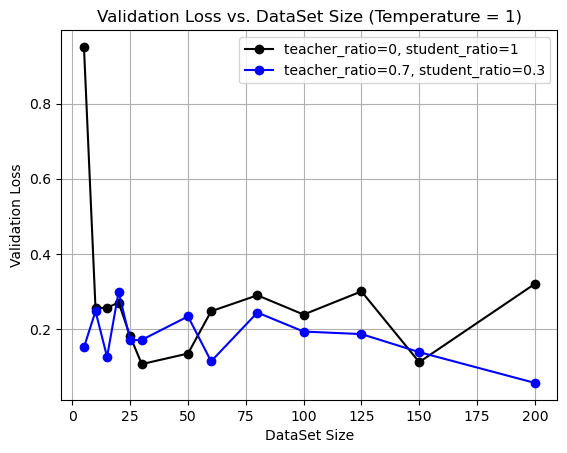

In [23]:
plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label='teacher_ratio=0, student_ratio=1')
plt.plot(train_sizes, mean_val_losses_KD, marker='o', color='blue', label=f'teacher_ratio={teacher_ratio}, student_ratio={round(1-teacher_ratio, 1)}')
plt.title(f'Validation Loss vs. DataSet Size (Temperature = {temperature})')
plt.xlabel('DataSet Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

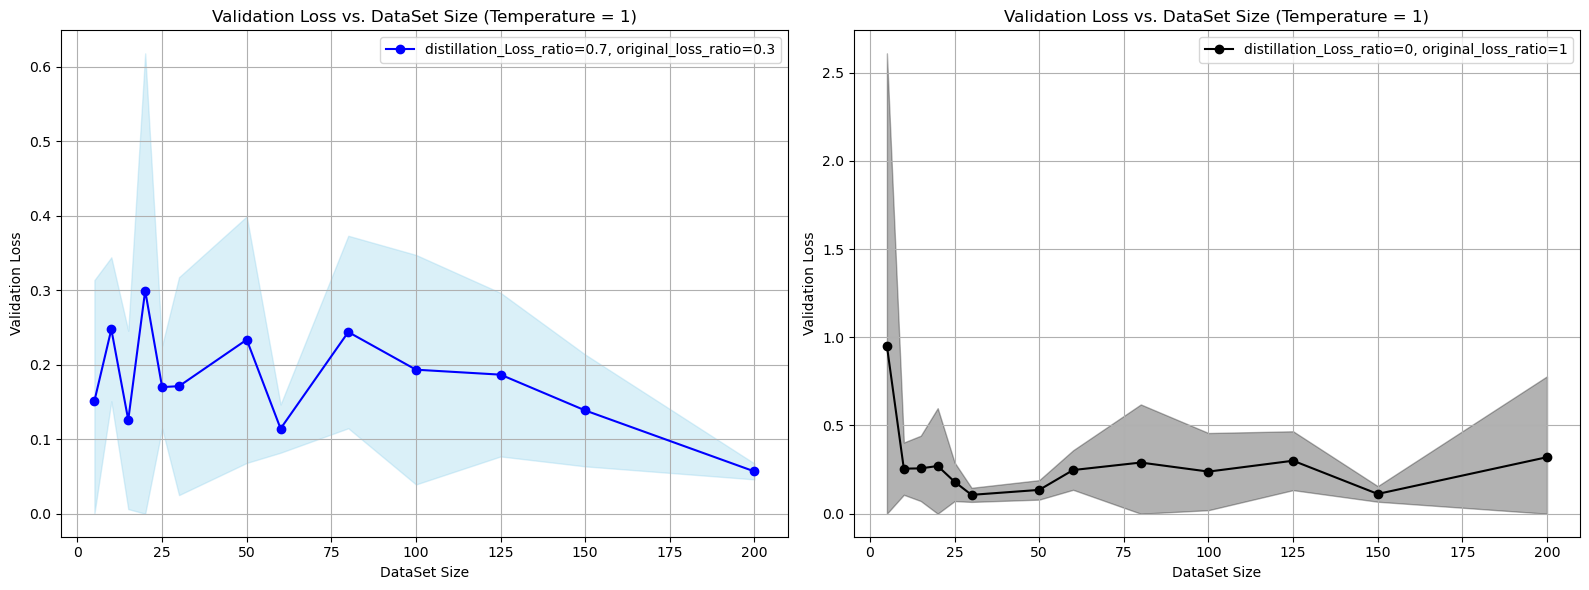

In [7]:
plt.figure(figsize=(16, 6))

# 圖1
plt.subplot(1, 2, 1)
plt.plot(train_sizes, mean_val_losses_KD, marker='o', color='b', label=f'distillation_Loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 1)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses_KD) - np.array(std_val_losses_KD)), 
                 np.array(mean_val_losses_KD) + np.array(std_val_losses_KD), color='skyblue', alpha=0.3)
plt.title(f'Validation Loss vs. DataSet Size (Temperature = {temperature})')
plt.xlabel('DataSet Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()

# 圖2
plt.subplot(1, 2, 2)
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label='distillation_Loss_ratio=0, original_loss_ratio=1')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title(f'Validation Loss vs. DataSet Size (Temperature = {temperature})')
plt.xlabel('DataSet Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()  # 避免重疊
plt.show()


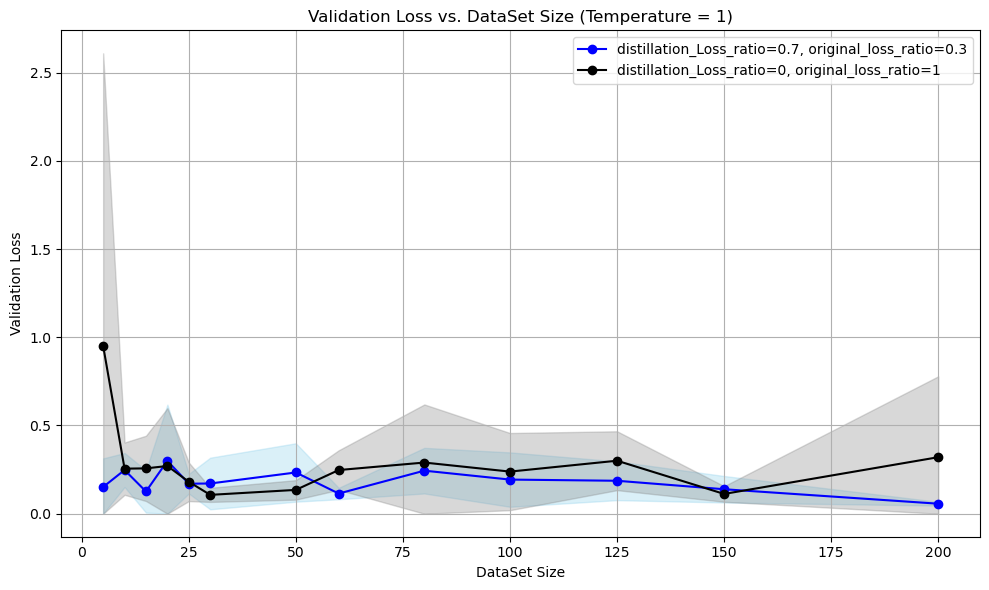

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, mean_val_losses_KD, marker='o', color='b', 
         label=f'distillation_Loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 1)}')
plt.fill_between(train_sizes, 
                 np.maximum(0, np.array(mean_val_losses_KD) - np.array(std_val_losses_KD)), 
                 np.array(mean_val_losses_KD) + np.array(std_val_losses_KD), 
                 color='skyblue', alpha=0.3)

plt.plot(train_sizes, mean_val_losses, marker='o', color='black', 
         label='distillation_Loss_ratio=0, original_loss_ratio=1')
plt.fill_between(train_sizes, 
                 np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), 
                 color='gray', alpha=0.3)

plt.title(f'Validation Loss vs. DataSet Size (Temperature = {temperature})')
plt.xlabel('DataSet Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


印出來看看👀


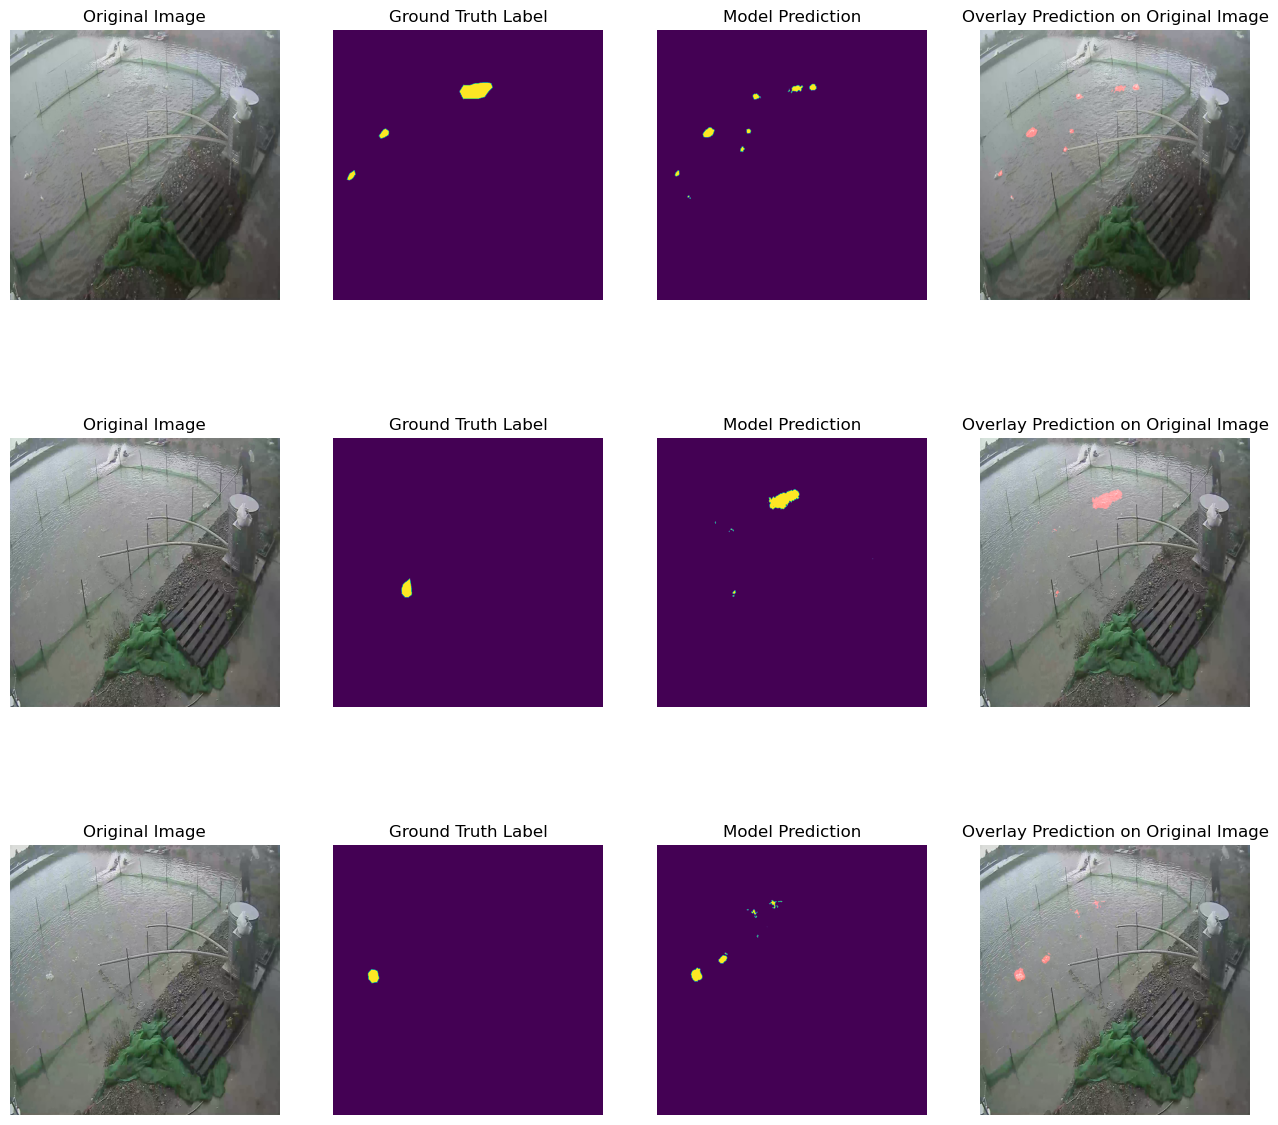

outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
tensor([[[[ -2.0832,  -2.0832,  -2.1452,  ...,  -1.7280,  -1.7433,  -1.7433],
          [ -2.0832,  -2.0832,  -2.1452,  ...,  -1.7280,  -1.7433,  -1.7433],
          [ -2.1851,  -2.1851,  -2.2392,  ...,  -1.7452,  -1.7572,  -1.7572],
          ...,
          [ -0.6144,  -0.6144,  -0.6369,  ...,  -1.5958,  -1.5224,  -1.5224],
          [ -0.5758,  -0.5758,  -0.6054,  ...,  -1.5985,  -1.5178,  -1.5178],
          [ -0.5758,  -0.5758,  -0.6054,  ...,  -1.5985,  -1.5178,  -1.5178]],

         [[-30.8480, -30.8480, -30.6619,  ..., -23.9093, -24.2678, -24.2678],
          [-30.8480, -30.8480, -30.6619,  ..., -23.9093, -24.2678, -24.2678],
          [-30.9881, -30.9881, -30.8245,  ..., -24.1413, -24.4262, -24.4262],
          ...,
          [-29.1844, -29.1844, -28.8491,  ..., -27.8986, -27.0567, -27.0567],
          [-30.5558, -30.5558, -30.2031,  ..., -28.0505, -27.1278, -27.1278],
          [-30.5558, -30.5558, -30.2031,  ..., -28.0505,

In [11]:
print("印出來看看👀")
showSegmentationResult(segformer_model_distillation, val_dataset, num_images=3)

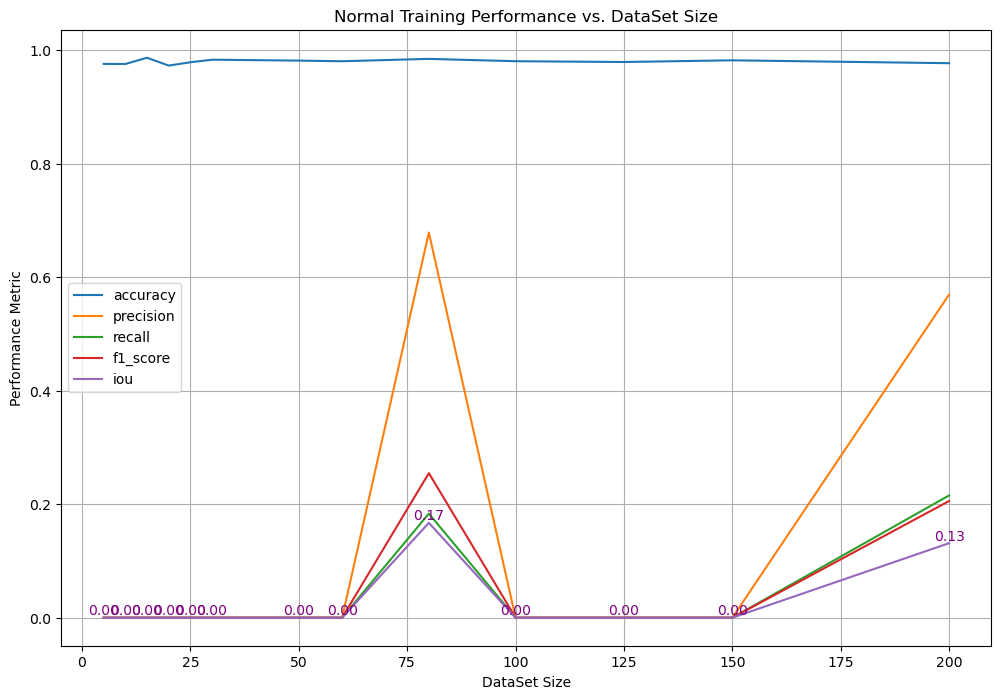

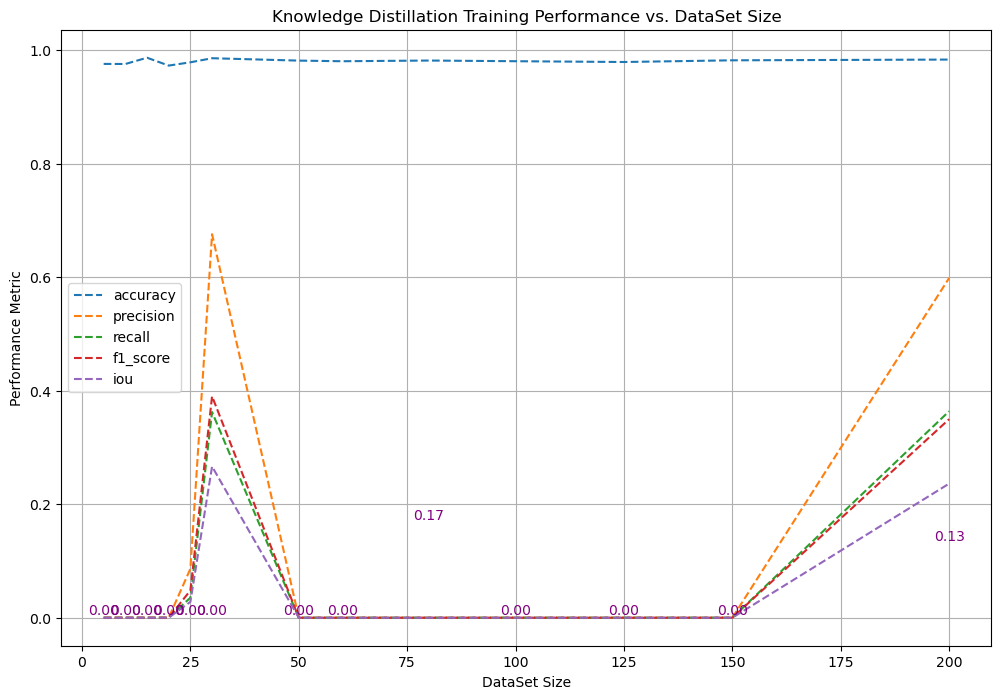

In [24]:
# Normal Training
plt.figure(figsize=(12, 8))
for key in all_metrics_normal.keys():
    plt.plot(train_sizes, all_metrics_normal[key], label=f'{key}')
    if key == 'iou':
        for i, txt in enumerate(all_metrics_normal[key]):
            plt.text(train_sizes[i], txt, f'{txt:.2f}', ha='center', va='bottom', color='purple')
plt.title('Normal Training Performance vs. DataSet Size')
plt.xlabel('DataSet Size')
plt.ylabel('Performance Metric')
plt.legend()
plt.grid(True)
plt.show()

# Knowledge Distillation Training
plt.figure(figsize=(12, 8))
for key in all_metrics_KD.keys():
    plt.plot(train_sizes, all_metrics_KD[key], label=f'{key}', linestyle='--')
    if key == 'iou':
        for i, txt in enumerate(all_metrics_normal[key]):
            plt.text(train_sizes[i], txt, f'{txt:.2f}', ha='center', va='bottom', color='purple')
plt.title('Knowledge Distillation Training Performance vs. DataSet Size')
plt.xlabel('DataSet Size')
plt.ylabel('Performance Metric')
plt.legend()
plt.grid(True)
plt.show()


### 以下備用 🤗

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def cal_iou(model, dataset, num_images=10):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    total_iou = 0.0

    for i, idx in enumerate(range(min(len(dataset), num_images))):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))   
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Compute IoU
        prediction_mask = (labels == 1)
        target_mask = (target.squeeze() == 1).numpy()  # Assuming your ground truth is also a binary mask

        metrics = compute_metrics(prediction_mask, target_mask)
        print(metrics)
        intersection = np.logical_and(target_mask, prediction_mask)
        union = np.logical_or(target_mask, prediction_mask)
        iou = intersection.sum() / union.sum()
        total_iou += iou

    average_iou = total_iou / num_images
    print(f"Average IoU over {num_images} images: {average_iou}")

    return average_iou

def compute_metrics(prediction, ground_truth, calculate_accuracy=True, calculate_precision=True, calculate_recall=True, calculate_f1=True):
    """
    Compute performance metrics for binary classification.

    :param prediction: Predicted binary mask
    :param ground_truth: Ground truth binary mask
    :param calculate_accuracy: Whether to calculate accuracy
    :param calculate_precision: Whether to calculate precision
    :param calculate_recall: Whether to calculate recall
    :param calculate_f1: Whether to calculate F1 score
    :return: Dictionary with requested metrics
    """
    TP, FP, TN, FN = calculate_confusion_matrix_elements(prediction, ground_truth)

    metrics = {}

    if calculate_accuracy:
        metrics['accuracy'] = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    if calculate_precision:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        metrics['precision'] = precision

    if calculate_recall:
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['recall'] = recall

    if calculate_f1:
        if 'precision' not in metrics:
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        if 'recall' not in metrics:
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['f1_score'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return metrics

def calculate_confusion_matrix_elements(prediction, ground_truth):
    TP = np.sum((prediction == 1) & (ground_truth == 1))
    FP = np.sum((prediction == 1) & (ground_truth == 0))
    TN = np.sum((prediction == 0) & (ground_truth == 0))
    FN = np.sum((prediction == 0) & (ground_truth == 1))

    return TP, FP, TN, FN


cal_iou(segformer_model, val_dataset)

In [ ]:
import numpy as np
import torch

def evaluate_metrics(model, dataset):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    total_metrics = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'iou': 0.0}
    num_images = len(dataset)

    for idx in range(num_images):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        prediction_mask = (labels == 1)
        target_mask = (target.squeeze() == 1).numpy()  # Assuming your ground truth is also a binary mask

        metrics = compute_metrics(prediction_mask, target_mask)
        intersection = np.logical_and(target_mask, prediction_mask)
        union = np.logical_or(target_mask, prediction_mask)
        iou = intersection.sum() / union.sum()

        for key in total_metrics.keys():
            if key in metrics:
                total_metrics[key] += metrics[key]
        total_metrics['iou'] += iou

    # Calculate average of each metric
    for key in total_metrics.keys():
        total_metrics[key] /= num_images

    print(f"Average metrics over {num_images} images: {total_metrics}")

    return total_metrics

# Assuming you have segformer_model and val_dataset defined
evaluate_metrics(segformer_model, val_dataset)
